# K-Nearest Neighbors (k-NN)

run this cell load the [autoreload](https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html?highlight=autoreload) extension. This allows us to edit `.py` source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data preprocessing / Visualization

### Setup

In [3]:
import os
import torch
import torchvision
import matplotlib.pyplot as plt
import statistics

#increase the default figure size
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 16

### Load the CIFAR-10 dataset

Download address:https://www.cs.toronto.edu/~kriz/cifar.html

But here I use torchvision.datasets 

In [24]:
# 定义数据预处理方式，将图像转换为 Tensor 并归一化到 [0, 1] 范围
transform = torchvision.transforms.ToTensor()

# 下载并加载训练集
# root：数据保存路径
# train=True：指定下载训练集
# download=True：如果本地没有，则自动下载
# transform：应用上面定义的预处理
trainset = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform)

# 下载并加载测试集
testset = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform)

# 注：PyTorch 的 Tensor 默认是 FloatTensor
x_train = torch.stack([img for img, _ in trainset])
y_train = torch.tensor([label for _, label in trainset])

x_test = torch.stack([img for img, _ in testset])
y_test = torch.tensor([label for _, label in testset])

# 打印 Tensor 的形状以确认
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: torch.Size([50000, 3, 32, 32])
y_train shape: torch.Size([50000])
x_test shape: torch.Size([10000, 3, 32, 32])
y_test shape: torch.Size([10000])


This cell visualizes some random examples from the training set (function `tensor_to_image` in the file `knn.py` )

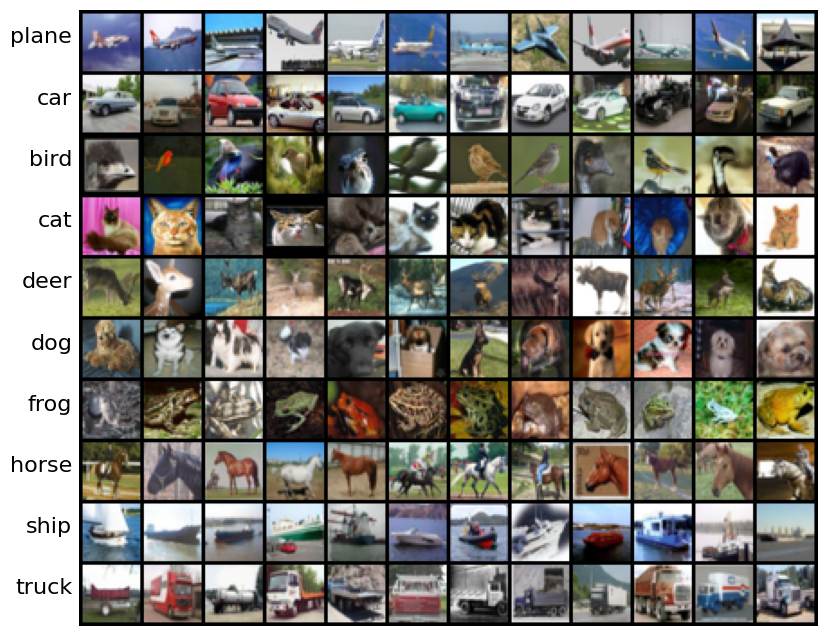

In [5]:
import random
from knn import tensor_to_image

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
samples_per_class = 12
samples = []
for y, cls in enumerate(classes):
    plt.text(-4, 34 * y + 18, cls, ha='right')
    idxs, = (y_train == y).nonzero(as_tuple=True)
    for i in range(samples_per_class):
        idx = idxs[random.randrange(idxs.shape[0])].item()
        samples.append(x_train[idx])
img = torchvision.utils.make_grid(samples, nrow=samples_per_class)
plt.imshow(tensor_to_image(img))
plt.axis('off')
plt.show()

## Subsample the dataset

Using a small sample of the full dataset will make the code run much faster, allowing for more interactive and efficient development.

In [25]:
random.seed(0)

# 定义子样本大小
num_train = 5000  
num_test = 500    

#trainset
train_indices_full = list(range(len(x_train)))
train_indices_subsampled = random.sample(train_indices_full, num_train)

x_train = x_train[train_indices_subsampled].clone()
y_train = y_train[train_indices_subsampled].clone()

# testset
test_indices_full = list(range(len(x_test)))
test_indices_subsampled = random.sample(test_indices_full, num_test)

x_test = x_test[test_indices_subsampled].clone()
y_test = y_test[test_indices_subsampled].clone()

print("\n--- After subsampling ---")
print(f"Subsampled x_train shape: {x_train.shape}")
print(f"Subsampled y_train shape: {y_train.shape}")
print(f"Subsampled x_test shape: {x_test.shape}")
print(f"Subsampled y_test shape: {y_test.shape}")


--- After subsampling ---
Subsampled x_train shape: torch.Size([5000, 3, 32, 32])
Subsampled y_train shape: torch.Size([5000])
Subsampled x_test shape: torch.Size([500, 3, 32, 32])
Subsampled y_test shape: torch.Size([500])


## KNN

### Compute distances : Naive implementation

compute the distances between all training examples and all test examples

use explicit loops (function `compute_distances_two_loops` in the file `knn.py` )

In [11]:
from knn import compute_distances_two_loops

dists = compute_distances_two_loops(x_train, x_test)
print('dists has shape: ', dists.shape)

dists has shape:  torch.Size([1000, 500])


As a visual debugging step, we can visualize the distance matrix, where each row is a test example and each column is a training example.

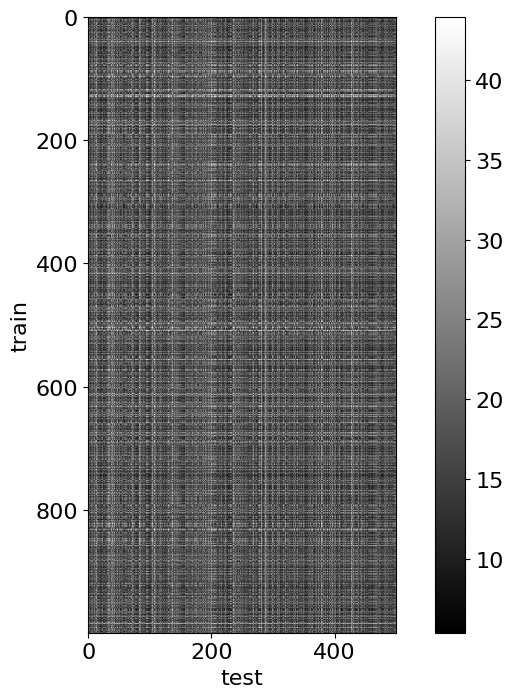

In [12]:
plt.imshow(dists.numpy(), cmap='gray', interpolation='none')
plt.colorbar()
plt.xlabel('test')
plt.ylabel('train')
plt.show()

## Compute distances: Vectorization

The process of eliminating explict loops from your code is called **vectorization**.

use no loops (function `compute_distances_no_loops` in the file `knn.py` )

check the correctness of our implementation by comparing the fully vectorized version against the original naive version

Note that we do the comparison with 64-bit floating points for increased numeric precision

In [13]:
from knn import compute_distances_two_loops
from knn import compute_distances_no_loops

torch.manual_seed(0)
x_train_rand = torch.randn(100, 3, 16, 16, dtype=torch.float64)
x_test_rand = torch.randn(100, 3, 16, 16, dtype=torch.float64)

dists_two = compute_distances_two_loops(x_train_rand, x_test_rand)
dists_none = compute_distances_no_loops(x_train_rand, x_test_rand)
difference = (dists_two - dists_none).pow(2).sum().sqrt().item()
print('Difference: ', difference)
if difference < 1e-4:
  print('Good! The distance matrices match')
else:
  print('Uh-oh! The distance matrices are different')

Difference:  3.5277570268892787e-13
Good! The distance matrices match


## Predict labels

uses those distances together with the training labels to predict labels for test samples (function `predict_labels` in the file `knn.py` )

## encapsulation

`KnnClassifer` class in the file `knn.py`  

## Classification on CIFAR-10

test our K-NN clasifier on a subset of CIFAR-10, using k=1

In [27]:
from knn import KnnClassifier

classifier = KnnClassifier(x_train, y_train)
classifier.check_accuracy(x_test, y_test, k=1)

Got 146 / 500 correct; accuracy is 29.20%


29.2

increase to k=5

In [30]:
from knn import KnnClassifier

classifier = KnnClassifier(x_train, y_train)
classifier.check_accuracy(x_test, y_test, k=5)

Got 140 / 500 correct; accuracy is 28.00%


28.0

## Cross-validation

We have not implemented the full k-Nearest Neighbor classifier, but the choice of $k=5$ was arbitrary. We will use **cross-validation** to set this hyperparameter in a more principled manner. (function `knn_cross_validate` in the file `knn.py` )

In [32]:
from knn import knn_cross_validate

k_to_accuracies = knn_cross_validate(x_train, y_train, num_folds=5)

for k, accs in sorted(k_to_accuracies.items()):
    print('k = %d got accuracies: %r' % (k, accs))

Got 279 / 1000 correct; accuracy is 27.90%
Got 260 / 1000 correct; accuracy is 26.00%
Got 270 / 1000 correct; accuracy is 27.00%
Got 272 / 1000 correct; accuracy is 27.20%
Got 261 / 1000 correct; accuracy is 26.10%
Got 263 / 1000 correct; accuracy is 26.30%
Got 242 / 1000 correct; accuracy is 24.20%
Got 253 / 1000 correct; accuracy is 25.30%
Got 244 / 1000 correct; accuracy is 24.40%
Got 254 / 1000 correct; accuracy is 25.40%
Got 268 / 1000 correct; accuracy is 26.80%
Got 258 / 1000 correct; accuracy is 25.80%
Got 261 / 1000 correct; accuracy is 26.10%
Got 252 / 1000 correct; accuracy is 25.20%
Got 271 / 1000 correct; accuracy is 27.10%
Got 276 / 1000 correct; accuracy is 27.60%
Got 269 / 1000 correct; accuracy is 26.90%
Got 259 / 1000 correct; accuracy is 25.90%
Got 244 / 1000 correct; accuracy is 24.40%
Got 276 / 1000 correct; accuracy is 27.60%
Got 281 / 1000 correct; accuracy is 28.10%
Got 272 / 1000 correct; accuracy is 27.20%
Got 263 / 1000 correct; accuracy is 26.30%
Got 236 / 1

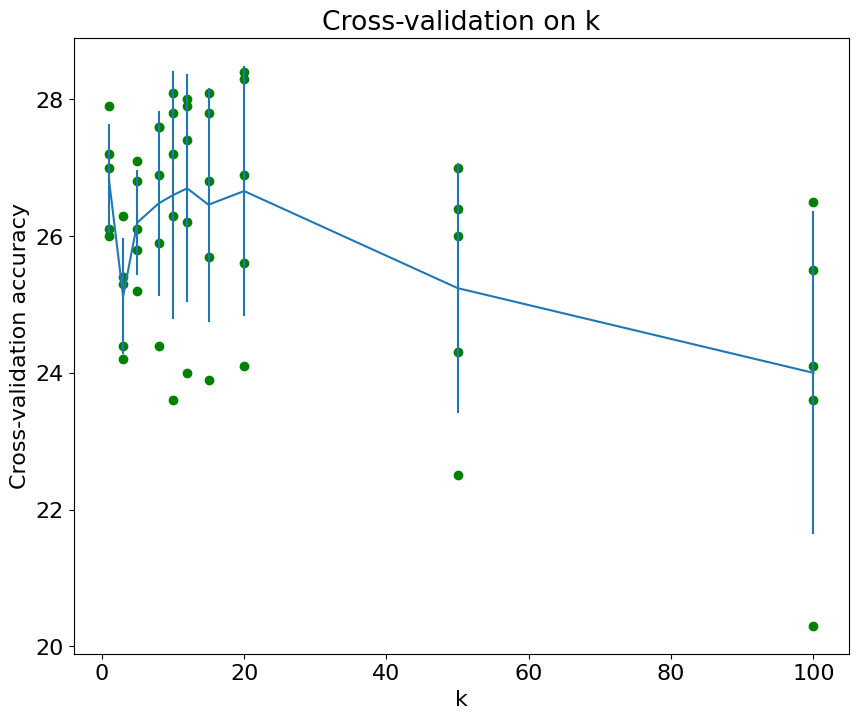

In [33]:
ks, means, stds = [], [], []

for k, accs in sorted(k_to_accuracies.items()):
  plt.scatter([k] * len(accs), accs, color='g')
  ks.append(k)
  means.append(statistics.mean(accs))
  stds.append(statistics.stdev(accs))
  
plt.errorbar(ks, means, yerr=stds)
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.title('Cross-validation on k')
plt.show()

Now we can use the results of cross-validation to select the best value for k (function `knn_get_best_k` in the file `knn.py`)

In [34]:
from knn import KnnClassifier
from knn import knn_get_best_k

best_k = knn_get_best_k(k_to_accuracies)    
print('Best k is ', best_k)

classifier = KnnClassifier(x_train, y_train)
classifier.check_accuracy(x_test, y_test, k=best_k)

Best k is  1
Got 146 / 500 correct; accuracy is 29.20%


29.2

## Entire training and testing

In [35]:
from knn import KnnClassifier

x_train_all = torch.stack([img for img, _ in trainset])
y_train_all = torch.tensor([label for _, label in trainset])

x_test_all = torch.stack([img for img, _ in testset])
y_test_all = torch.tensor([label for _, label in testset])

classifier = KnnClassifier(x_train_all, y_train_all)
classifier.check_accuracy(x_test_all, y_test_all, k=best_k)

Got 3539 / 10000 correct; accuracy is 35.39%


35.39